# **PROBLEMA DE NEGOCIO**


---




La urgencia por detectar fraudes en transacciones móviles de dinero ha llevado a una empresa del segmento Fintech a buscar soluciones innovadoras. Como científicos de datos hemos sido convocados para desarrollar un modelo de machine learning que pueda distinguir de manera precisa entre transacciones legítimas y fraudulentas, estableciendo así un estándar de seguridad en el sector financiero móvil global.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Realizar limpieza de datos, manejar valores faltantes, codificación de variables categóricas y normalización/escalado de datos.

**2. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables llaves y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Regresión Logística, Árboles de Decisión, Random Forest, Naive Bayes, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como precisión, recall, área bajo la curva ROC, y F1-score. Seleccionar el modelo con el mejor rendimiento para la detección de transacciones bancarias fraudulentas.

# **1. Configuración del Ambiente**


---




In [1]:
#Instalación de librerias
#!pip install -U imbalanced-learn
#!pip install ydata-profiling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
global df_banco, resultados

# **2. Preprocesamiento de Datos**


---


In [2]:
# Leemos nuestra data principal
df_banco = pd.read_csv("./data/fraude.csv")


In [3]:
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
#@title
def procesar_datos():
  global df_banco
  #Creamos una variable con la combinación de la primera letra (nombre de origen/nombre de destino)
df_banco["type2"]=df_banco["nameOrig"].str[0:1]+df_banco["nameDest"].str[0:1]

# Calcular la hora 1 a 24
df_banco['hora'] = ((df_banco['step'] - 1) % 24) + 1


  # Calcular el valor del día para cada hora
df_banco['Dia'] = (df_banco['step'] - 1) // 24 + 1
  # Calcular el rango de tiempo para cada hora
df_banco['time_range'] = (
    pd.cut(
        ((df_banco['step'] - 1) % 24) + 1,  # Ajustar las horas de 1 a 24
        bins=[0, 6, 12, 18, 24],
        labels=['madrugada', 'mañana', 'tarde', 'noche'],
        ordered=False
    )
    .astype('object')
)
  #Calcular el dia de la semana 
df_banco['dia_semana'] = df_banco['Dia'].apply(lambda x: 'lunes' if x % 7 == 1 else 'martes' if x % 7 == 2 else 'miércoles' if x % 7 == 3 else 'jueves' if x % 7 == 4 else 'viernes' if x % 7 == 5 else 'sábado' if x % 7 == 6 else 'domingo')

 #Eliminar valores ausentes
df_banco=df_banco.dropna()
  #Eliminar duplicados
df_banco=df_banco.drop_duplicates().reset_index(drop=True)   




procesar_datos()



# 3. Exploración y Feature Engineering

In [5]:
df_banco

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type2,hora,Dia,time_range,dia_semana
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,CM,1,1,madrugada,lunes
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,CM,1,1,madrugada,lunes
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,CC,1,1,madrugada,lunes
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,CC,1,1,madrugada,lunes
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,CM,1,1,madrugada,lunes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,CC,23,31,noche,miércoles
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,CC,23,31,noche,miércoles
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,CC,23,31,noche,miércoles
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,CC,23,31,noche,miércoles


## Transacciones totales 


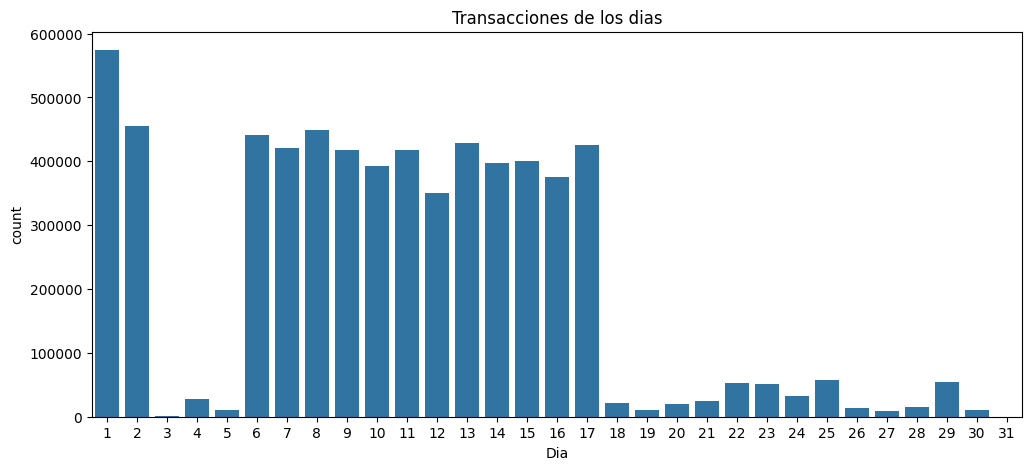

In [6]:
fig, axs = plt.subplots(figsize=(12, 5))

sns.countplot(x="Dia", data=df_banco)
plt.title("Transacciones de los dias")
plt.show()

Como podemos observar, el primer día del mes es cuando se registran la mayoría de las transacciones.

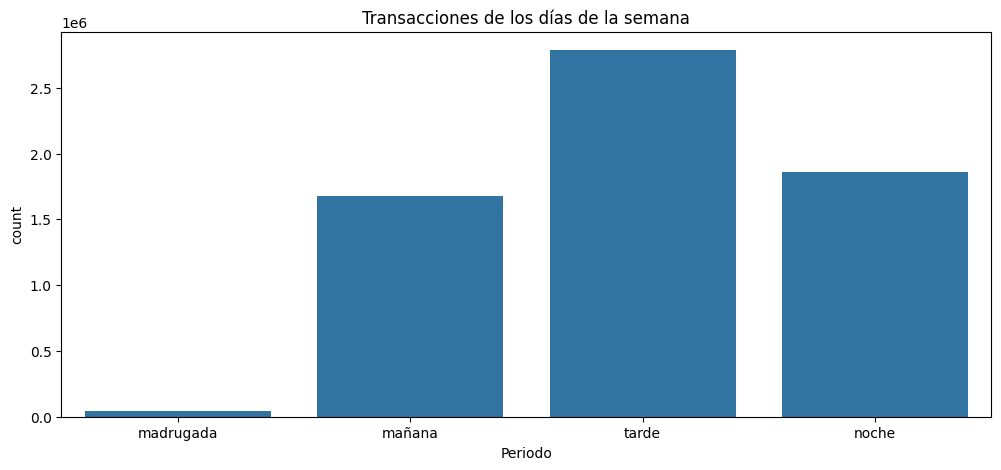

In [7]:
fig, axs = plt.subplots(figsize=(12, 5))

sns.countplot(x="time_range", data=df_banco)
plt.title("Transacciones de los días de la semana")
plt.xlabel("Periodo")
plt.show()

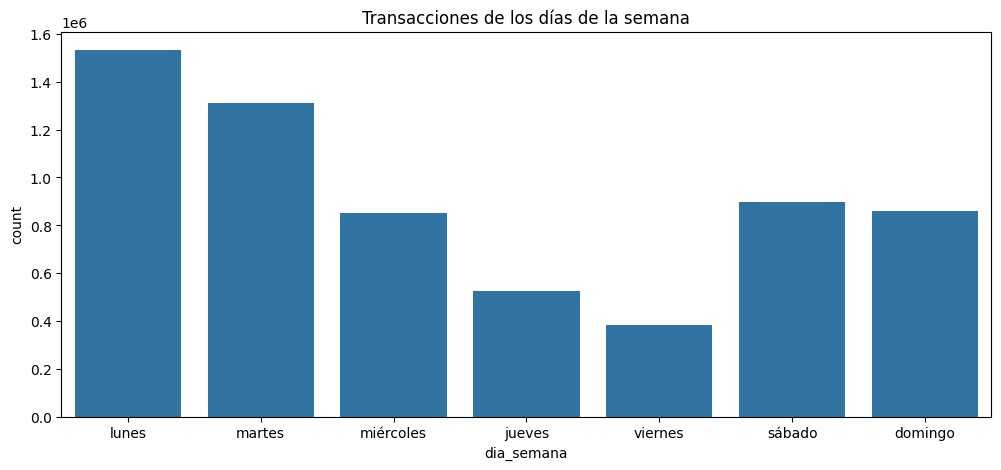

In [8]:
fig, axs = plt.subplots(figsize=(12, 5))

sns.countplot(x="dia_semana", data=df_banco)
plt.title("Transacciones de los días de la semana")
plt.show()

Los días Lunes son cuando se registran la mayoría de las transacciones.

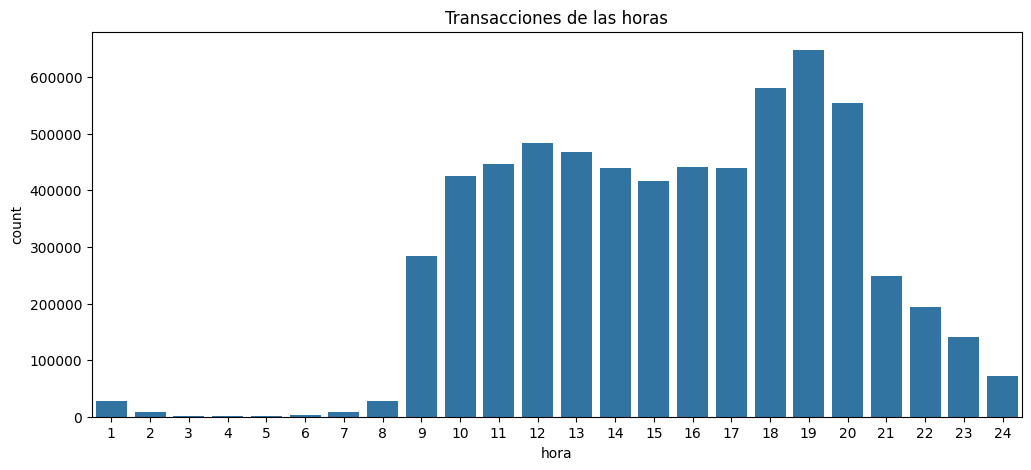

In [9]:
fig, axs = plt.subplots(figsize=(12, 5))

sns.countplot(x="hora", data=df_banco)
plt.title("Transacciones de las horas")
plt.show()

Tenemos un pico de transacciones en la horas 18:00hrs,19:00hrs y 20:00hrs que puede corresponder a un rango de la Tarde.

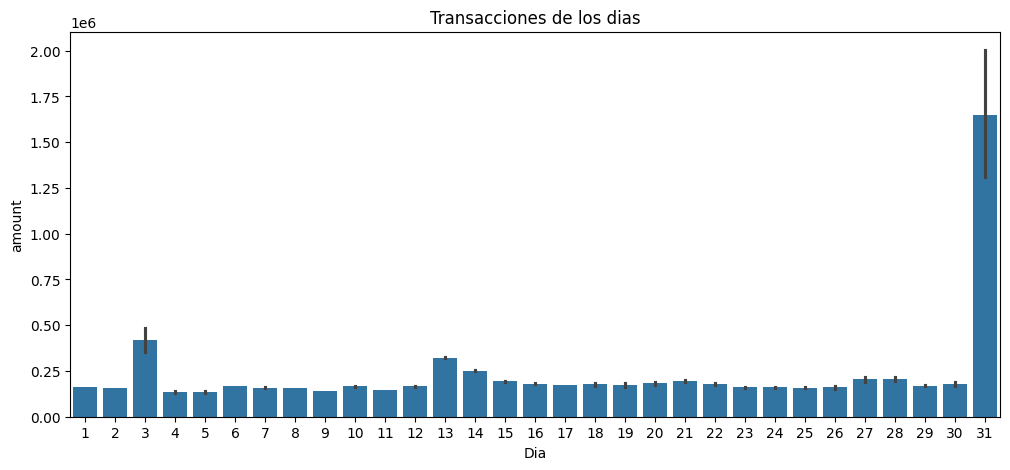

In [10]:
fig, axs = plt.subplots(figsize=(12, 5))

sns.barplot(x="Dia",y="amount", data=df_banco)
plt.title("Transacciones de los dias")
plt.show()

Según los datos, el día 31 es aquel en el que se registra el mayor volumen de transacciones en términos de cantidad total de dinero transaccionado.

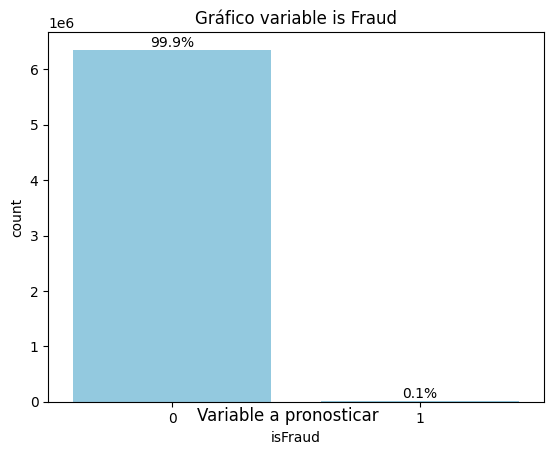

In [11]:
gen_cnt = df_banco['isFraud'].value_counts()
npkmn = gen_cnt.values.sum()
sns.countplot(data=df_banco, x="isFraud",color="skyblue")
for i in range(len(gen_cnt)):
   cnt = gen_cnt[i]
   pcnt = '{:0.1f}%'.format(100*cnt/npkmn)
   plt.text(i, cnt, pcnt, va='bottom', ha='center')
plt.title("Gráfico variable is Fraud")
plt.suptitle("Variable a pronosticar",y=0.100)

plt.show()

Disponemos de un conjunto de datos que consta de 6 millones de registros, y observamos un desbalance significativo en la variable que queremos pronosticar.

El 99.9% de los registros corresponden a transacciones legítimas, mientras que solo el 0.1% son transacciones fraudulentas. Esta marcada discrepancia en la distribución de clases presenta un desafío importante a la hora de realizar predicciones de fraude, ya que contamos con una cantidad muy limitada de datos fraudulentos para entrenar nuestros modelos.

## Evaluando la variable Fraude

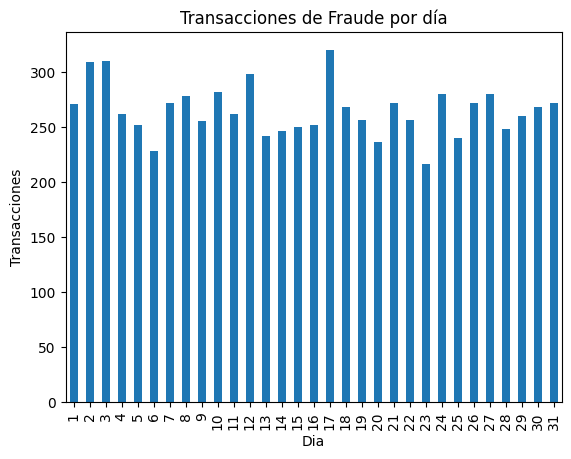

In [12]:
# Extraen las variables solamente contengan un fraude 
valores_fraude=df_banco[df_banco["isFraud"]==1]
# 
valores_fraude.groupby("Dia")["isFraud"].sum().plot(kind="bar")
plt.title("Transacciones de Fraude por día")
plt.ylabel("Transacciones")
plt.show()


Podemos observar que las transacciones fraudulentas ocurren todos los días, con picos notablemente altos al inicio de la semana y hacia la mitad del mes.

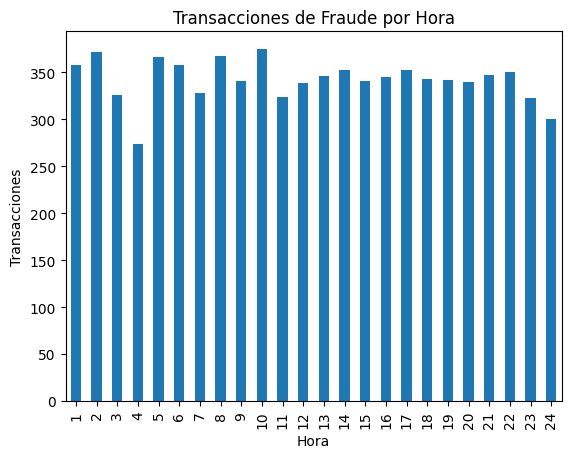

In [13]:
valores_fraude.groupby("hora")["isFraud"].sum().plot(kind="bar")
plt.title("Transacciones de Fraude por Hora")
plt.xlabel("Hora")
plt.ylabel("Transacciones")
plt.show()

Igualmente, notamos que las horas con mayores transacciones, incluyendo las fraudulentas, son durante la madrugada.

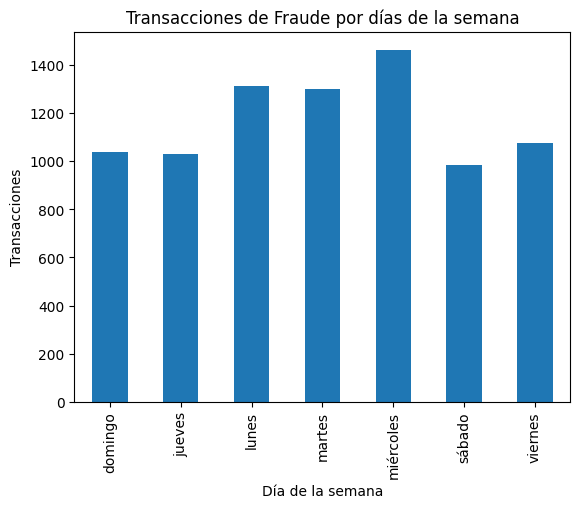

In [14]:
valores_fraude.groupby("dia_semana")["isFraud"].sum().plot(kind="bar")
plt.title("Transacciones de Fraude por días de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Transacciones")
plt.show()


En cuanto a los días de la semana, observamos un pico notable los miércoles. 

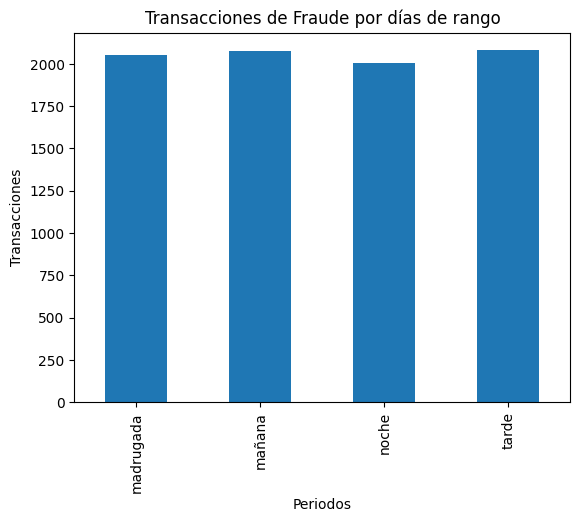

In [15]:
valores_fraude.groupby("time_range")["isFraud"].sum().plot(kind="bar")
plt.title("Transacciones de Fraude por días de rango")
plt.xlabel("Periodos")
plt.ylabel("Transacciones")
plt.show()


En cuanto al rango horario, regularmente observamos valores similares, especialmente durante la madrugada y la mañana.

In [16]:
#Creamos la funcion con las variables que vamos a trabajar para el modelo.
def feature_engineering():

 # Volvemos a definir las variables globales.
   global df_banco
  #Eliminamos las Variables que no aportan al modelo
   columnas_eliminar = ['nameOrig', 'nameDest', 'isFlaggedFraud',
                       'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',"step","dia_semana"]

   df_banco = df_banco.drop(columnas_eliminar,axis=1)
   #Utilizamos el metodo de get_dummies para crear nuevas variables que aporten al modelo.
   df_banco = pd.get_dummies(df_banco, drop_first=True,dtype=int)

feature_engineering()


In [17]:
df_banco.head(2)

,amount,isFraud,hora,Dia,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CM,time_range_mañana,time_range_noche,time_range_tarde
0,9839.64,0,1,1,0,0,1,0,1,0,0,0
1,1864.28,0,1,1,0,0,1,0,1,0,0,0


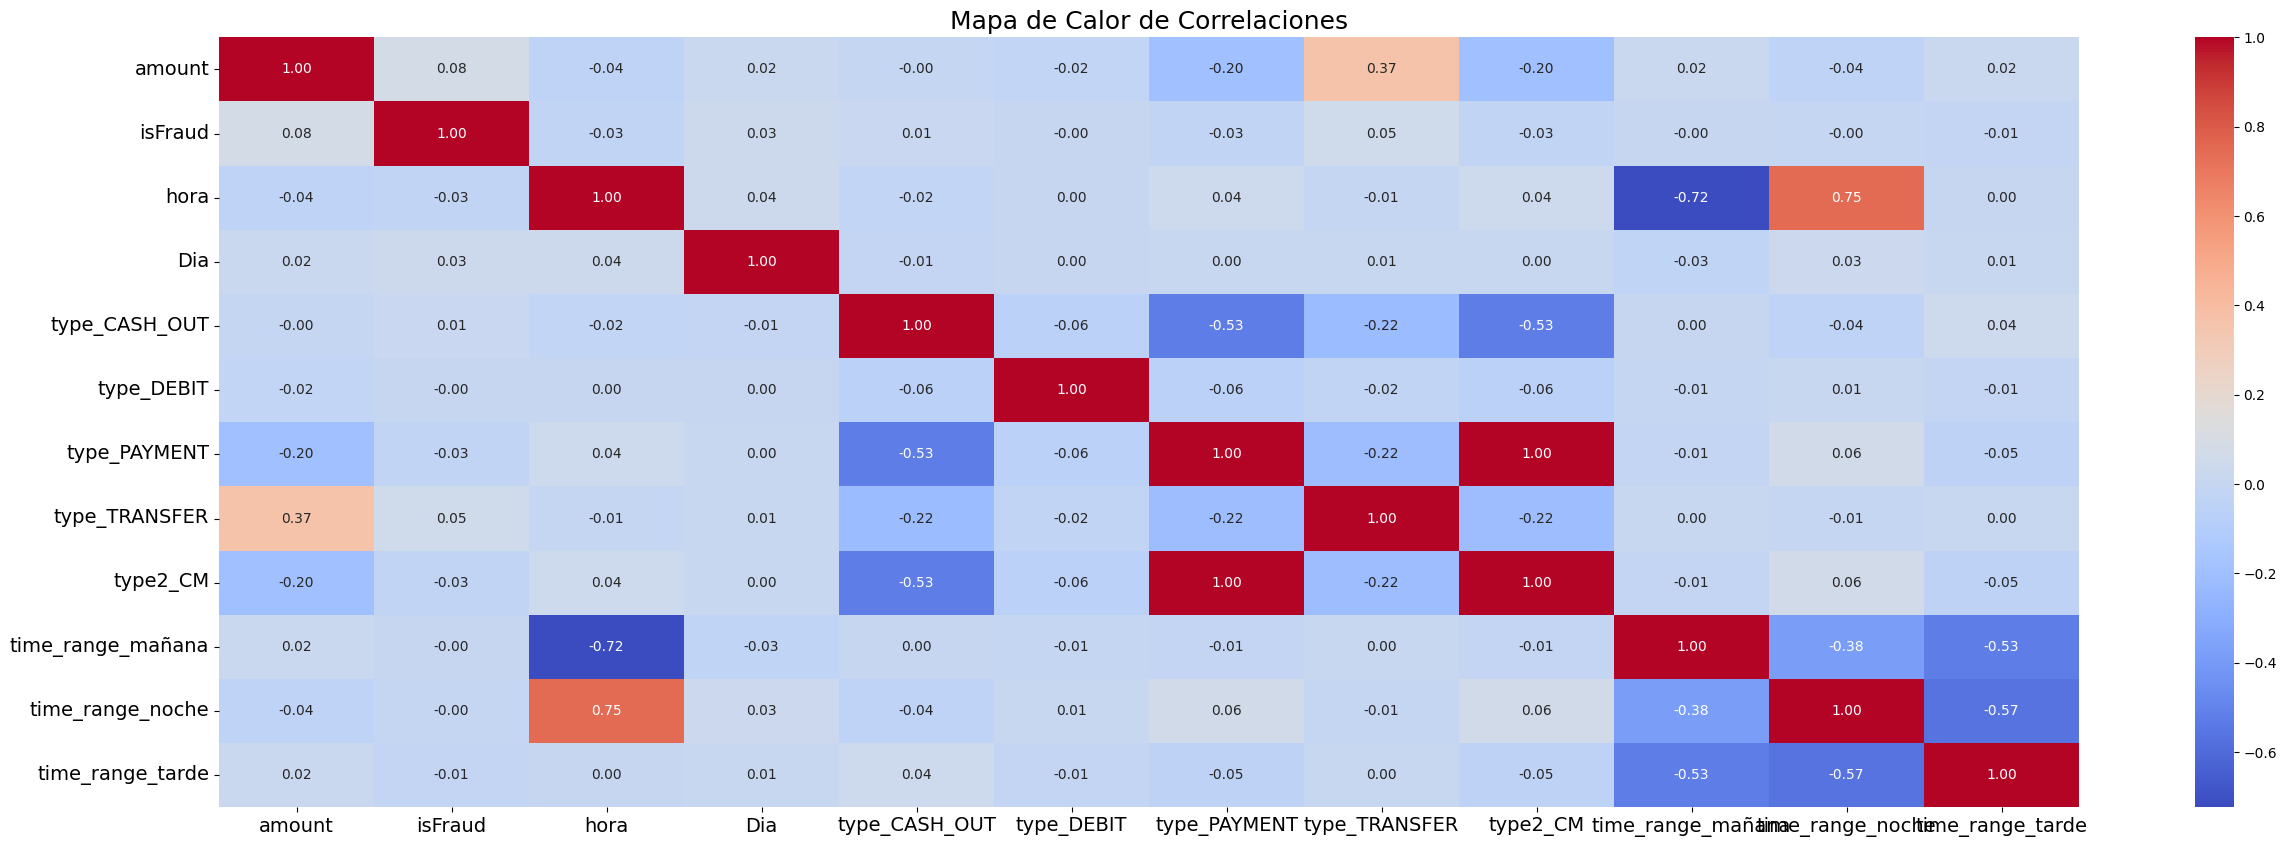

In [18]:
#Creación del Mapa de Calor
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

Podemos bservar la correlación entre todas las características de tu conjunto de datos para observar el comportamiento en el los diferentes modelos de ML

In [19]:


def estandarizar_datos():
    global X_train,y_train,X_test,y_test,df_banco
    features = df_banco.drop('isFraud', axis=1) #x
    target = df_banco['isFraud'] #y

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)


    numeric=["amount","Dia","hora"]
    scaler = StandardScaler()
    scaler.fit(X_train[numeric])
    X_train[numeric] = scaler.transform(X_train[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])

estandarizar_datos()

La estandarización de valores en el contexto del aprendizaje automático es un paso común en el preprocesamiento de datos. Se realiza con el objetivo de ajustar las características de un conjunto de datos para que tengan una media de 0 y una desviación estándar de 1. Esto se logra restando la media de cada característica y dividiendo por la desviación estándar.

+ Evita problemas con escalas diferentes.

+ Facilita la interpretación

+ Facilita la convergencia del modelo




# **4. Evaluación y Selección del Modelo**


---

In [49]:
def lista_modelos():

    global model_functions
    # Se creean los diferentes modelos que utilizaremos para entrenar los datos.

    decision_tree = DecisionTreeClassifier(
        criterion='entropy', random_state=42,
        class_weight="balanced",
        max_depth=7,min_samples_split=3,
        max_leaf_nodes=2,max_features="sqrt"
        
    )
   
    random_forest = RandomForestClassifier(
        criterion='entropy', max_depth=9,
        n_estimators=7, random_state=42,
        bootstrap=True, 
        max_leaf_nodes= 7,
        class_weight="balanced",
        #learning_rate=1,
        min_samples_leaf=10,
        max_features=1.0,
      

    )


    Logistic_Regression=LogisticRegression(
        C=1.0,penalty='l2',random_state=42,
        solver="newton-cg",
        class_weight="balanced"
    )
   
   
    HistGradient = HistGradientBoostingClassifier( 
        max_depth= 7,
        scoring="f1", 
        random_state=42,
        learning_rate=0.1,
        max_iter=150,
        max_leaf_nodes=32,
        class_weight="balanced"
    )


    model_functions = {
      
        "Árbol de Decisión": decision_tree,
        "Random Forest": random_forest,
        "HistGradientBoostingClassifier": HistGradient,
        "Logistic Regression": Logistic_Regression
    
    }


In [65]:
def crea_modelos():
    import time
    global  resultados


    name_model = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    auc_roc_list = []
    matrizgraf=[]

    lista_modelos()

    for name, function in model_functions.items():
        print('======'*10)
        star = time.time()
        print(f'Empezando {name}')
        time.sleep(1)

        name_model.append(name)

        model = function
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)
        accuracy_list.append(accuracy)
        precision = precision_score(y_test, predictions)
        precision_list.append(precision)
        recall = recall_score(y_test, predictions)
        recall_list.append(recall)
        matriz = confusion_matrix(y_test, predictions)
        matrizgraf.append(matriz)
      
        print('---Matriz de Confusión---')
        print(matriz)
        print('----'*10)
        f1_rating = f1_score(y_test, predictions)
        f1_score_list.append(f1_rating)
        auc_roc = roc_auc_score(y_test, predictions)
        auc_roc_list.append(auc_roc)

        finish = time.time()
        duracion = finish - star
        print(f"El Modelo {name} tardó {round(duracion)} segundos.")

    resultados = {
        'Model': name_model,
        'Accuracy': accuracy_list,
        'Precision': precision_list,
        'Recall': recall_list,
        'F1-score': f1_score_list,
        'AUC-ROC': auc_roc_list,
        'matriz': matrizgraf
    }

    

Resumen de las metricas

La acuraccy del modelo es esencialmente el porcentaje total de predicciones correctas en relación con el número total de predicciones.

La precisión de una clase indica qué tan confiable es el modelo al determinar si un punto pertenece a esa clase. 

El recall de una clase expresa qué tan bien puede el modelo detectar esa clase. Por ejemplo, para "fraudes" podría ser de 1, mientras que para "transacciones legítimas" sería de 0.

El puntaje F1 de una clase se calcula como la media armónica de la precisión y el recall (2 x precisión x recall / (precisión + recall)). Digamos que combina precisión y recall en una sola métrica. 

In [66]:
crea_modelos()
for i, model in enumerate(resultados['Model']):
    print('-*-*'*8)
    print(f"\nModelo: {model}")
    print(f"Exactitud: {resultados['Accuracy'][i]}")
    print(f"Precisión: {resultados['Precision'][i]}")
    print(f"Recall: {resultados['Recall'][i]}")
    print(f"F1-score: {resultados['F1-score'][i]}")
    print(f"AUC-ROC: {resultados['AUC-ROC'][i]}\n")
print('-*-'*8)




Empezando Árbol de Decisión
---Matriz de Confusión---
[[1456642  132045]
 [    953    1015]]
----------------------------------------
El Modelo Árbol de Decisión tardó 7 segundos.
Empezando Random Forest
---Matriz de Confusión---
[[1390058  198629]
 [    204    1764]]
----------------------------------------
El Modelo Random Forest tardó 126 segundos.
Empezando HistGradientBoostingClassifier
---Matriz de Confusión---
[[1415126  173561]
 [    186    1782]]
----------------------------------------
El Modelo HistGradientBoostingClassifier tardó 30 segundos.
Empezando Logistic Regression
---Matriz de Confusión---
[[1340947  247740]
 [    244    1724]]
----------------------------------------
El Modelo Logistic Regression tardó 30 segundos.
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Modelo: Árbol de Decisión
Exactitud: 0.9163879030965232
Precisión: 0.007628137682248609
Recall: 0.5157520325203252
F1-score: 0.015033918890896702
AUC-ROC: 0.7163181134133463

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Modelo: Ran

# **5. Evaluación y Selección del Modelo**


---


In [67]:


def visualiza_resultados():
    global resultados

    results_df = pd.DataFrame(resultados)
    results_df.set_index('Model', inplace=True)

    results_df = results_df.T
    colors = ['#0077b6', '#CDDBF3','#9370DB', '#DDA0DD']

    sns.set_style('white')
    ax = results_df.plot(
        kind='bar',
        figsize=(12, 6),
        colormap='viridis',
        rot=0,
        color=colors,
        width=0.8
    )
    plt.title('Comparación de Métricas por Modelo')
    plt.xlabel('Métricas')
    plt.ylabel('Puntaje')
    plt.legend(title='Modelos',loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Agregar etiquetas de valor en cada barra con formato de dos decimales
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
        
        
    
    plt.tight_layout()


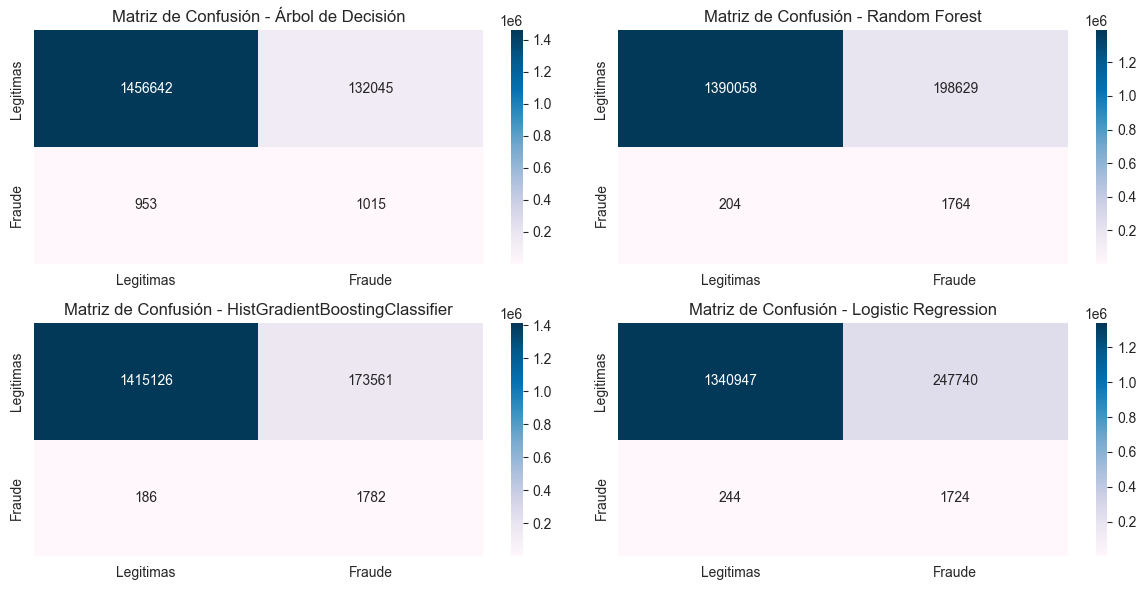

In [111]:
# Crear la matriz
num_modelos = len(resultados['Model'])

num_filas = (num_modelos + 1) // 2 
num_columnas = 2

# Crear una nueva figura para los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(12, 6))


for i, model in enumerate(resultados['Model']):
    # Obtener la posición del subplot
    fila = i // num_columnas
    columna = i % num_columnas
    

    matriz_confusion = resultados['matriz'][i]
   
    sns.heatmap(matriz_confusion, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="PuBu", ax=axes[fila, columna])

    axes[fila, columna].set_title(f'Matriz de Confusión - {model}')
    
plt.tight_layout()
plt.show()

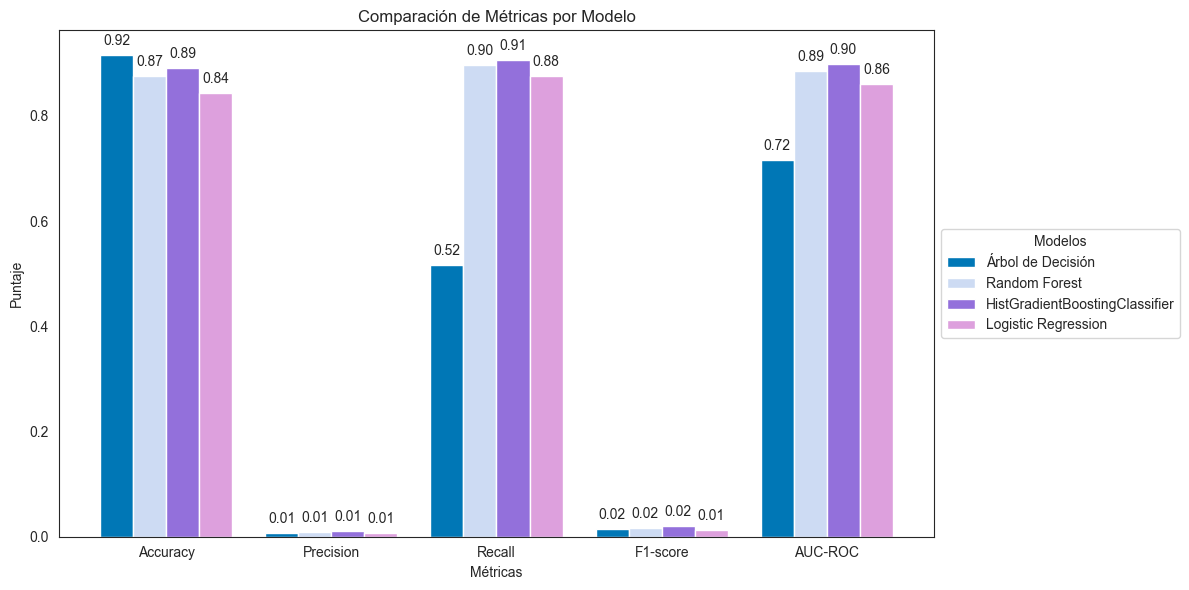

In [64]:
visualiza_resultados()

# Conclusiones:

## Decision Tree Classifier

| Algorithm            | Estrategia                  | Recall | Auc-Roc | Precision | Accuracy | f1-score |
|----------------------|-----------------------------|--------|---------|-----------|----------|----------|
| DecisionTreeClassifier | Penalización para compensar | 0.51   | 0.71    | 0.007     | 0.91     | 0.01     |


En cuanto a las variables tenemos:
Recall: De todas las transacciones fraudulentas, el 51% fueron identificadas correctamente

Accuracy: Refiere  99.87% de las predicciones son correctas pero no nos dejemos engañar.

Precisión: De las transacciones predichas como fraude, el 0.007% realmente son fraude.

F1-score: Es equilibrio entre precisión y recall, una puntuación más alta indica un mejor rendimiento

AUC-ROC El área bajo la curva ROC, una medida de la capacidad del modelo para distinguir entre las clases, cuando sea igual a 1 tiene overfitting y si esta muy abajo de 1 entonces tiene underfitting. En este caso  0.71. 

Matriz de Confusión.


|  1456642  |   132045  |
|-----------|-----------|
|    953    |    1015   |



Verdaderos Positivos Tenemos un **1456642** de las predicciones verdaderas. 

Verdaderos Negativos:Tenemos **1015** realmente eran fraude y se predijeron correctamente.

Falsos Negativos: Fallo en **953** de las cuales las detecto como transacciones verdaderas cuando realmente eran fraudes. (Esta métrica puede generar perdidas a la empresa)

Falsos positivos:Contamos con **132045** de los cuales conto como transacciones fraudulentas cuando realmente eran legitimas.
(pero ustedes piensen… ¿qué prefiere la compañía bancaria? ¿tener que revisar esos casos manualmente ó fallar en detectar los verdaderos casos de fraude?)

## Random Forest Classifier

| Algorithm              | Estrategia                  | Recall | Auc-Roc | Precision | Accuracy | f1-score |
|------------------------|-----------------------------|--------|---------|-----------|----------|----------|
| RandomForestClassifier | Penalización para compensar | 0.89   | 0.88    | .008      | 0.87     | 0.01     |



En cuanto a las variables tenemos:

Recall: De todas las transacciones fraudulentas, el 89% fueron identificadas correctamente.

Accuracy: Refiere  87% de las predicciones son correctas pero no nos dejemos engañar.

Precisión: De las transacciones predichas como fraude, el .8% realmente son fraude.

F1-score: Es equilibrio entre precisión y recall, una puntuación más alta indica un mejor rendimiento

AUC-ROC El área bajo la curva ROC, una medida de la capacidad del modelo para distinguir entre las clases, cuando sea igual a 1 tiene overfitting y si esta muy abajo de 1 entonces tiene underfitting. En este caso  0.88. 

Matriz de Confusión.


|  1390058  |   198629  |
|-----------|-----------|
|    204    |    1782   |



Verdaderos Positivos Tenemos un **1390058** de las predicciones verdaderas. 

Verdaderos Negativos:Tenemos **1782** realmente eran fraude y se predijeron correctamente aumentarón considerablemente.

Falsos Negativos: Fallo en **204** de las cuales las detecto como transacciones verdaderas cuando realmente eran fraudes. (Esta métrica puede generar perdidas a la empresa),pero realmente es muy pequeña. Ya que el recall es alto.

Falsos positivos:Contamos con **198629** de los cuales conto como transacciones fraudulentas cuando realmente eran legitimas, deberiamos de mejorar esta métrica.
(pero ustedes piensen… ¿qué prefiere la compañía bancaria? ¿tener que revisar esos casos manualmente ó fallar en detectar los verdaderos casos de fraude?)

## HistGradient Boosting Classifierr


| Algorithm                        | Estrategia                  | Recall | Auc-Roc | Precision | Accuracy | f1-score |
|----------------------------------|-----------------------------|--------|---------|-----------|----------|----------|
| HistGradientBoostingClassifier   | Penalización para compensar | 0.90   | 0.89    | 0.01      | 0.88     | 0.02     |



En cuanto a las variables tenemos:

Recall: De todas las transacciones fraudulentas, el 0.90% fueron identificadas correctamente.

Accuracy: Refiere  89% de las predicciones son correctas pero no nos dejemos engañar.

Precisión: De las transacciones predichas como fraude, el 0.01% realmente son fraude.

F1-score: Es equilibrio entre precisión y recall, una puntuación más alta indica un mejor rendimiento

AUC-ROC El área bajo la curva ROC, una medida de la capacidad del modelo para distinguir entre las clases, cuando sea igual a 1 tiene overfitting y si esta muy abajo de 1 entonces tiene underfitting. En este caso  0.89. 

Matriz de Confusión.


| 1415126 |  173561 |
|---------|---------|
|   186   |    1782 |




Verdaderos Positivos Tenemos un **1423500** de las predicciones verdaderas. 

Verdaderos Negativos:Tenemos **1782** realmente eran fraude y se predijeron correctamente aumentarón considerablemente.

Falsos Negativos: Fallo en **186** de las cuales las detecto como transacciones verdaderas cuando realmente eran fraudes,tenemos una baja en cuanto al Random Forest. (Esta métrica puede generar perdidas a la empresa),pero realmente es muy pequeña. Ya que el recall es alto.


Falsos positivos:Contamos con **165187** de los cuales conto como transacciones fraudulentas cuando realmente eran legitimas, deberiamos de mejorar esta métrica.
(pero ustedes piensen… ¿qué prefiere la compañía bancaria? ¿tener que revisar esos casos manualmente ó fallar en detectar los verdaderos casos de fraude?)

## Logistic Regression

| Algorithm            | Estrategia                  | Recall | Auc-Roc | Precision | Accuracy | f1-score |
|----------------------|-----------------------------|--------|---------|-----------|----------|----------|
| Logistic Regression  | Penalización para compensar | 0.87   | 0.85    | 0.006     | 0.84     | 0.85     |

En cuanto a las variables tenemos:

Recall: De todas las transacciones fraudulentas, el 87% fueron identificadas correctamente.

Accuracy: Refiere  89% de las predicciones son correctas pero no nos dejemos engañar.

Precisión: De las transacciones predichas como fraude, el 0.006% realmente son fraude.

F1-score: Es equilibrio entre precisión y recall, una puntuación más alta indica un mejor rendimiento

AUC-ROC El área bajo la curva ROC, una medida de la capacidad del modelo para distinguir entre las clases, cuando sea igual a 1 tiene overfitting y si esta muy abajo de 1 entonces tiene underfitting. En este caso  0.85. 

Matriz de Confusión.


| 1340947 | 247740 |
|---------|--------|
|   244   |  1724  |




Verdaderos Positivos Tenemos un **1340947** de las predicciones verdaderas. 

Verdaderos Negativos:Tenemos **1724** realmente eran fraude y se predijeron correctamente aumentarón considerablemente.

Falsos Negativos: Fallo en **244** de las cuales las detecto como transacciones verdaderas cuando realmente eran fraudes. (Esta métrica puede generar perdidas a la empresa)

Falsos positivos:Contamos con **247740** de los cuales conto como transacciones fraudulentas cuando realmente eran legitimas, deberiamos de mejorar esta métrica, en este modelo aumento considerablemente.
(pero ustedes piensen… ¿qué prefiere la compañía bancaria? ¿tener que revisar esos casos manualmente ó fallar en detectar los verdaderos casos de fraude?)

# ¿Cúal Seria el mejor Modelo?


## HistGradient Boosting Classifier


| Algorithm                       | Estrategia                  | Recall | Auc-Roc | Precision | Accuracy | f1-score |
|---------------------------------|-----------------------------|--------|---------|-----------|----------|----------|
| HistGradientBoostingClassifier  | Penalización para compensar | 0.90   | 0.89    | 0.01      | 0.88     | 0.02     |


Matriz de Confusión.


| 1415126 |  173561 |
|---------|---------|
|   186   |   1782  |



En este escenario, el modelo demostró un desempeño superior al predecir con mayor precisión los verdaderos negativos, identificando correctamente 1782 transacciones fraudulentas. Además, exhibió una baja tasa de falsos positivos, con solo 186 casos de transacciones legítimas clasificadas erróneamente como fraudes. Este aspecto es crítico, ya que minimiza el riesgo de pérdidas para la empresa.

Sin embargo, hay margen para mejorar la identificación de los falsos negativos, que representan 173561 transacciones legítimas erróneamente etiquetadas como fraudulentas. Reducir esta cifra no solo optimizará los costos asociados con la verificación de estas transacciones, sino que también mejorará la experiencia del cliente al evitar bloqueos innecesarios de sus transacciones legítimas.







## Estrategias para mejorar el Modelo

 Lidiar con un conjunto de datos de seis millones de registros, donde apenas el 0.01% se clasifican como fraudulentos, plantea un desafío significativo que los científicos de datos debemos abordar. Nuestro objetivo fue reducir las transacciones incorrectamente identificadas como fraude, logrando un alto recall. Sin embargo, debido al volumen de datos, enfrentamos un problema de falsos positivos, donde transacciones legítimas se clasifican erróneamente como fraudulentas, con consecuencias potencialmente costosas para el departamento encargado de investigar estas incidencias.

Para mitigar este problema, proponemos la inclusión de más características en nuestro modelo de detección de fraude. Esto nos permitirá mejorar nuestras predicciones y reducir la tasa de falsos positivos, aumentando así la eficiencia y precisión de nuestro sistema de detección.

# Pruebas realizadas para Obtener el Mejor Modelo con la mejor estrategia
(Sin balancear,Over sampling,Combination, Penalización para compensar)

| Algorithm              | Strategy                    | Recall | Auc-Roc | Precision | Accuracy | f1-score | time (s) |
|------------------------|-----------------------------|--------|---------|-----------|----------|----------|----------|
| KNeighborsClassifier   | __n/d__                     | 0.051  | 0.52    | 0.70      | 0.99     | 0.09     | 203      |
| DecisionTreeClassifier | __n/d__                     | 0.49   | 0.74    | 0.49      | 0.99     | 0.49     | 68       |
| RandomForestClassifier | __n/d__                     | 0.15   | 0.57    | 0.89      | 0.99     | 0.26     | 37       |
| HistGradient           | __n/d__                     | 0.31   | 0.65    | 0.39      | 0.99     | 0.35     | 22       |
| Logistic Regression    | __n/d__                     | 0.002  | 0.50    | 0.14      | 0.99     | 0.004    | 398      |
| KNeighborsClassifier   | over_sampling               | 0.60   | 0.79    | 0.04      | 0.98     | 0.07     | 735      |
| DecisionTreeClassifier | over_sampling               | 0.55   | 0.76    | 0.03      | 0.97     | 0.05     | 112      |
| RandomForestClassifier | over_sampling               | 0.86   | 0.87    | 0.009     | 0.88     | 0.01     | 60       |
| HistGradient           | over_sampling               | 0.78   | 0.87    | 0.04      | 0.97     | 0.07     | 212      |
| Logistic Regression    | over_sampling               | 0.87   | 0.85    | 0.006     | 0.84     | 0.01     | 45       |
| KNeighborsClassifier   | **Combination**             | 0.60   | 0.79    | 0.04      | 0.98     | 0.07     | 836      |
| DecisionTreeClassifier | **Combination**             | 0.56   | 0.77    | 0.03      | 0.98     | 0.06     | 116      |
| RandomForestClassifier | **Combination**             | 0.86   | 0.872   | 0.009     | 0.88     | 0.01     | 69       |
| HistGradient           | **Combination**             | 0.80   | 0.88    | 0.03      | 0.97     | 0.06     | 134      |
| Logistic Regression    | **Combination**             | 0.87   | 0.86    | 0.007     | 0.84     | 0.01     | 43       |
| DecisionTreeClassifier | Penalización para compensar | 0.51   | 0.71    | 0.46      | 0.91     | 0.01     | 65       |
| RandomForestClassifier | Penalización para compensar | 0.89   | 0.88    | .008      | 0.87     | 0.01     | 27       |
| HistGradient           | Penalización para compensar | 0.90   | 0.89    | 0.01      | 0.89     | 0.02     | 22       |
| Logistic Regression    | Penalización para compensar | 0.87   | 0.85    | 0.006     | 0.84     | 0.85     | 466      |


Como podemos observar al principio sin utilizar ninguna estrategia los modelos salian realmente sin aprender nada con metricas muy por debajo de lo esperado y dando mas peso a las transacciones legitimas lo cual no era correcto. 

Para esto se utilizaron diferentes estrategias para balancear los datos utilizando:

+ over sampling

+ Combination under y over sampling

+ Penalización para compesar 


Inicialmente, al enfrentarnos al problema sin utilizar ninguna estrategia de balanceo de datos, los modelos mostraban un bajo rendimiento, con métricas significativamente por debajo de lo esperado. Además, tendían a favorecer las transacciones legítimas, lo cual era inapropiado y no cumplía con nuestro objetivo de detectar fraudes de manera efectiva.

Para abordar esta situación, implementamos diversas estrategias de balanceo de datos, incluyendo oversampling, la combinación de undersampling y oversampling, y la penalización para compensar desbalances. Cada una de estas estrategias mejoró las métricas de rendimiento de los modelos.

Sin embargo, al evaluar las estrategias, la que proporcionó los mejores resultados fue la penalización para compensar, la cual se logró mediante el argumento class_weight='balanced' en los modelos. Esta estrategia demostró ser la más efectiva para mejorar las métricas de rendimiento en comparación con las otras estrategias consideradas.